In [1]:
%matplotlib inline
import intake
import matplotlib.pyplot as plt
import psyplot.project as psy
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
import math
from clisops.core import subset
import clisops as cl
print("Using roocs/clisops in version %s" % cl.__version__)
print("Using xESMF in version %s" % xe.__version__)

xr.set_options(display_style='html');

Using roocs/clisops in version 0.3.1
Using xESMF in version 0.4.0


### Load the datasets

In [2]:
# Load intake catalogue
col_url = "/work/ik1017/Catalogs/mistral-cordex.json"
col_url = "/home/dkrz/k204212/git/intake-esm/mistral-cordex.json"
col = intake.open_esm_datastore(col_url)

In [3]:
"""
# Example without lat_vertices/lon_vertices
cat = col.search(driving_model_id=["MPI-M-MPI-ESM-LR", "NCC-NorESM1-M"],
                 model_id=["KNMI-RACMO22E"],
                 experiment_id="rcp85",
                 member="r1i1p1", 
                 variable_id="tas",
                 time_range="207101-208012",
                 CORDEX_domain=["EUR-11"])
"""

# Example with lat_vertices/lon_vertices
cat = col.search(driving_model_id=["MPI-M-MPI-ESM-LR"],
                 model_id=["GERICS-REMO2015"],
                 experiment_id="rcp85",
                 member="r1i1p1", 
                 variable_id="tas",
                 time_range="207101-208012",
                 CORDEX_domain=["EUR-22"])
#"""

In [4]:
cat.df

,variable_id,CORDEX_domain,driving_model_id,experiment_id,member,model_id,rcm_version_id,frequency,time_range,institute_id,version,path
0,tas,EUR-22,MPI-M-MPI-ESM-LR,rcp85,r1i1p1,GERICS-REMO2015,v1,mon,207101-208012,GERICS,v20191029,/mnt/lustre01/work/kd0956/CORDEX/data/cordex/o...


In [5]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})

dset_dict.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'CORDEX_domain.driving_model_id.institute_id.model_id.experiment_id.frequency'


dict_keys(['EUR-22.MPI-M-MPI-ESM-LR.GERICS.GERICS-REMO2015.rcp85.mon'])

In [6]:
ds = dset_dict['EUR-22.MPI-M-MPI-ESM-LR.GERICS.GERICS-REMO2015.rcp85.mon']
#ds = dset_dict['EUR-11.MPI-M-MPI-ESM-LR.KNMI.KNMI-RACMO22E.rcp85.mon']

### Take a look at the grid

In [7]:
ds

<xarray.Dataset>
Dimensions:                     (bnds: 2, member: 1, rlat: 201, rlon: 225, time: 120, vertices: 4)
Coordinates:
  * time                        (time) float64 4.424e+04 4.427e+04 ... 4.786e+04
  * rlat                        (rlat) float64 -22.88 -22.66 ... 20.9 21.12
  * rlon                        (rlon) float64 -29.86 -29.64 ... 19.2 19.42
    lat                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
    lon                         (rlat, rlon) float32 dask.array<chunksize=(201, 225), meta=np.ndarray>
    height                      float64 ...
  * member                      (member) <U6 'r1i1p1'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds                   (time, bnds) float64 dask.array<chunksize=(120, 2), meta=np.ndarray>
    rotated_latitude_longitude  int32 ...
    lat_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(201, 225, 4), meta=np.ndarray>
    lon_vertices                (rlat, rlon, vertices) float32 dask.array<chunksize=(201, 225, 4), meta=np.ndarray>
    tas                         (member, time, rlat, rlon) float32 dask.array<chunksize=(1, 120, 201, 225), meta=np.ndarray>
Attributes:
    institution:                    Helmholtz-Zentrum Geesthacht, Climate Ser...
    institute_id:                   GERICS
    experiment_id:                  rcp85
    source:                         GERICS-REMO2015
    model_id:                       GERICS-REMO2015
    forcing:                        N/A
    parent_experiment_id:           N/A
    parent_experiment_rip:          N/A
    branch_time:                    0.0
    contact:                        gerics-cordex@hzg.de
    history:                        There is no special history for this expe...
    comment:                        CORDEX-CORE Europe RCM REMO EUR-22. Data_...
    references:                     http://www.remo-rcm.de
    initialization_method:          1
    physics_version:                1
    CORDEX_domain:                  EUR-22
    driving_experiment:             MPI-M-MPI-ESM-LR, rcp85, r1i1p1
    driving_model_id:               MPI-M-MPI-ESM-LR
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        rcp85
    rcm_version_id:                 v1
    product:                        output
    experiment:                     RCP8.5
    frequency:                      mon
    creation_date:                  2019-06-05T09:56:05Z
    Conventions:                    CF-1.4
    project_id:                     CORDEX
    table_id:                       Table mon (Mar 2015) c0a10bad89df35dfced7...
    title:                          GERICS-REMO2015 model output prepared for...
    parent_experiment:              N/A
    modeling_realm:                 atmos
    realization:                    1
    cmor_version:                   2.9.1
    tracking_id:                    hdl:21.14103/95db45b7-49b7-4db4-ab6e-82d9...
    intake_esm_varname:             ['tas']
    intake_esm_dataset_key:         EUR-22.MPI-M-MPI-ESM-LR.GERICS.GERICS-REM...

In [8]:
ds["lon"].values
ds["lat"].values

array([[21.885447, 21.969408, 22.052855, ..., 25.383759, 25.32695 ,
        25.26954 ],
       [22.085527, 22.169744, 22.253443, ..., 25.595022, 25.538023,
        25.48042 ],
       [22.285551, 22.370022, 22.453976, ..., 25.806253, 25.749062,
        25.691265],
       ...,
       [58.403233, 58.554512, 58.705425, ..., 65.305435, 65.180954,
        65.05569 ],
       [58.551823, 58.703526, 58.854866, ..., 65.48063 , 65.3555  ,
        65.22958 ],
       [58.69966 , 58.851788, 59.00355 , ..., 65.655136, 65.52936 ,
        65.402794]], dtype=float32)

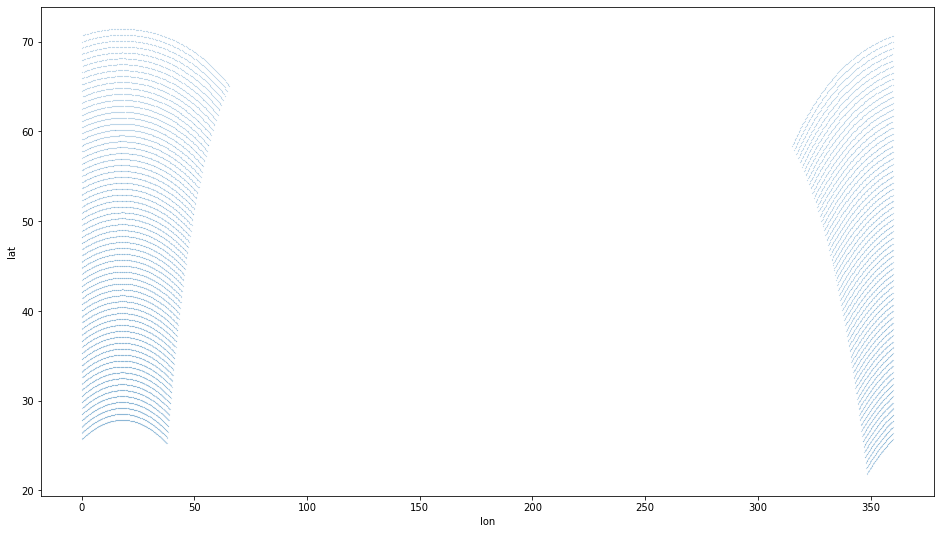

In [9]:
# plot grid locations

plt.figure(figsize=(16,9))
plt.scatter(ds['lon'][::3], ds['lat'][::3], s=0.01)  
#plt.ylim([20, 75])
#plt.xlim([-50, 70])
plt.xlabel('lon');
plt.ylabel('lat');

### Plot the data

/home/dkrz/k204212/conda-envs/xesmf0pt4/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


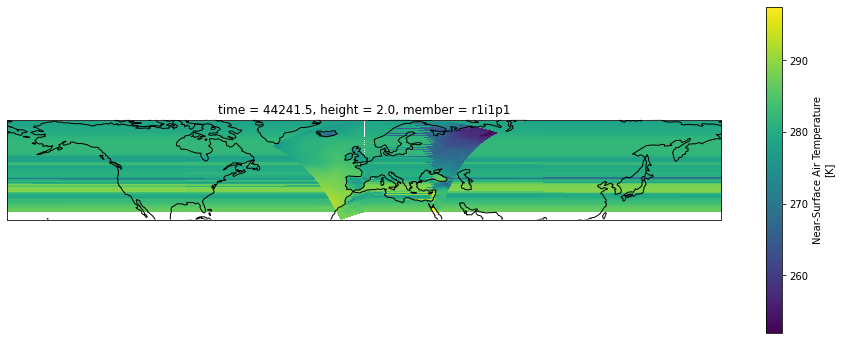

In [10]:
# Using matplotlib / cartopy / xarray
# Plotting data on curvilinear grids doesn't work properly 
#  for longitudes in [0, 360] rather than [-180, 180]

plt.figure(figsize=(16,6));
ax = plt.axes(projection=ccrs.PlateCarree());
ds.tas.isel(member=0, time=0).plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

### Set up and perform the regrid operation

In [11]:
# Read the target grid (1deg, SCRIP format provided by 
#   Charlie Zender in course of the CMIP6 regridding weights discussion:
#   https://docs.google.com/document/d/1BfVVsKAk9MAsOYstwFSWI2ZBt5mrO_Nmcu7rLGDuL08/edit
ds_scrip=xr.open_dataset("target_grids/cmip6_180x360_scrip.20181001.nc")

ds_scrip


# Alternatively specify a global 5 deg grid
# ds_out = xe.util.grid_global(5, 5) # global 5 degree grid
# ds_out

<xarray.Dataset>
Dimensions:          (grid_corners: 4, grid_rank: 2, grid_size: 64800)
Dimensions without coordinates: grid_corners, grid_rank, grid_size
Data variables:
    grid_dims        (grid_rank) int32 ...
    grid_area        (grid_size) float64 ...
    grid_imask       (grid_size) int32 ...
    grid_center_lat  (grid_size) float64 ...
    grid_center_lon  (grid_size) float64 ...
    grid_corner_lat  (grid_size, grid_corners) float64 ...
    grid_corner_lon  (grid_size, grid_corners) float64 ...
Attributes:
    title:                Equi-Angular grid 1x1 degree, dimensions 180x360, c...
    Conventions:          SCRIP
    created_by:           zender
    history:              Mon Sep 10 09:34:07 2018: ncks --dmm_in_mk -O --no_...
    NCO:                  netCDF Operators version 4.7.7-alpha03 (Homepage = ...
    latitude_grid_type:   Uniform/Equi-Angular latitude grid. Uniform/Equi-an...
    longitude_grid_type:  Greenwich at west edge of first longitude cell

In [12]:
print(ds_scrip["grid_corner_lon"].values)
print(ds_scrip["grid_corner_lat"].values)

[[  0.   1.   1.   0.]
 [  1.   2.   2.   1.]
 [  2.   3.   3.   2.]
 ...
 [357. 358. 358. 357.]
 [358. 359. 359. 358.]
 [359. 360. 360. 359.]]
[[-90. -90. -89. -89.]
 [-90. -90. -89. -89.]
 [-90. -90. -89. -89.]
 ...
 [ 89.  89.  90.  90.]
 [ 89.  89.  90.  90.]
 [ 89.  89.  90.  90.]]


In [13]:
# SCRIP format seems not to be supported by xESMF (though it is by ESMF)
# -> converting manually to (almost) CF format for a rectilinear grid following
#    https://github.com/JiaweiZhuang/xESMF/issues/5
#    https://github.com/JiaweiZhuang/xESMF/issues/74
#    https://github.com/JiaweiZhuang/xESMF/issues/14#issuecomment-369686779
# The bnds cannot be in CF format, as xESMF conservative regridding requires 
#    certain format of the bnds (see links above)
#  
#  [:,3]     [:,2]
#
#    x---------x
#    |         |
#    |    o    |
#    |         |
#    x---------x
#
#  [:,0]     [:,1]
#
# x - grid cell corners
# o - grid cell center
#
# lat/lon
lat=ds_scrip["grid_center_lat"].values.reshape((180,360))[:, 0]
lon=ds_scrip["grid_center_lon"].values.reshape((180,360))[0, :]

# lower and upper bounds
latb_l=ds_scrip["grid_corner_lat"].values[:, 0].reshape((180,360))[:, 0]
latb_u=ds_scrip["grid_corner_lat"].values[:, 3].reshape((180,360))[:, 0]
lonb_l=ds_scrip["grid_corner_lon"].values[:, 0].reshape((180,360))[0, :]
lonb_u=ds_scrip["grid_corner_lon"].values[:, 1].reshape((180,360))[0, :]

# reshape from (nlat,2) to (nlat+1)
lat_bnds=np.zeros(lat.shape[0]+1, dtype="double")
lat_bnds[:-1]=latb_l[:]
lat_bnds[-1]=latb_u[-1]

# reshape from (nlon,2) to (nlon+1)
lon_bnds=np.zeros(lon.shape[0]+1, dtype="double")
lon_bnds[:-1]=lonb_l[:]
lon_bnds[-1]=lonb_u[-1]
            
# Create dataset
ds_out=xr.Dataset(data_vars={"lat_b":(["lat1"], lat_bnds),
                             "lon_b":(["lon1"], lon_bnds)},
                  coords={"lat":(["lat"], lat),
                          "lon":(["lon"], lon)})

ds_out["lat"].attrs={"bounds":"lat_b",
                     "units":"degrees_north",
                     "long_name":"latitude",
                     "standard_name":"latitude"}
ds_out["lon"].attrs={"bounds":"lon_b",
                     "units":"degrees_east",
                     "long_name":"longitude",
                     "standard_name":"longitude"}
ds_out

<xarray.Dataset>
Dimensions:  (lat: 180, lat1: 181, lon: 360, lon1: 361)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Dimensions without coordinates: lat1, lon1
Data variables:
    lat_b    (lat1) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
    lon_b    (lon1) float64 0.0 1.0 2.0 3.0 4.0 ... 357.0 358.0 359.0 360.0

In [14]:
# Calculate bounds for input grid (assumes variables lat_vertices, lon_vertices)
# reshape from (nlat,nlon,4) to (nlat+1,nlon+1)
# TODO: Might not be 100% correct

lat_bnds=np.zeros(tuple([el+1 for el in list(ds["lat"].shape)]), dtype="double")
lat_bnds[:-1, :-1]=ds["lat_vertices"][:,:,3]
lat_bnds[-1, :-1]=ds["lat_vertices"][-1,:,2]
lat_bnds[:-1, -1]=ds["lat_vertices"][:,-1,1]
lat_bnds[-1, -1]=ds["lat_vertices"][-1,-1,0]
lon_bnds=np.zeros(tuple([el+1 for el in list(ds["lon"].shape)]), dtype="double")
lon_bnds[:-1, :-1]=ds["lon_vertices"][:,:,3]
lon_bnds[-1, :-1]=ds["lon_vertices"][-1,:,2]
lon_bnds[:-1, -1]=ds["lon_vertices"][:,-1,1]
lon_bnds[-1, -1]=ds["lon_vertices"][-1,-1,0]

ds_in=xr.Dataset(data_vars={"lat_b":(["y1","x1"], lat_bnds),
                            "lon_b":(["y1","x1"], lon_bnds)},
                  coords={"lat":(["y","x"], ds["lat"].values),
                          "lon":(["y","x"], ds["lon"].values)})

In [15]:
# Create regridding weights

def regrid(ds_in, ds_out, method):
    """Convenience function for calculating regridding weights"""
    return xe.Regridder(ds_in, ds_out, method) 

method_list = ['bilinear','nearest_s2d', 'conservative', 'conservative_normed', 'patch']

#In case of missing input grid bounds
#method_list = ['bilinear','nearest_s2d', 'patch']

regridder={}
for method in method_list:
    print()
    %time regridder[method]=regrid(ds_in, ds_out, method)
    print(regridder[method])    


CPU times: user 552 ms, sys: 49 ms, total: 601 ms
Wall time: 604 ms
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_201x225_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (201, 225) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

CPU times: user 31.5 s, sys: 39 ms, total: 31.5 s
Wall time: 31.5 s
xESMF Regridder 
Regridding algorithm:       nearest_s2d 
Weight filename:            nearest_s2d_201x225_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:           (201, 225) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

CPU times: user 2.44 s, sys: 65 ms, total: 2.51 s
Wall time: 2.51 s
xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            conservative_201x225_180x360.nc 
Reuse pre-computed weights? False 
Input grid shape:     

In [16]:
# Save to disk for later use:
for method in regridder: 
    print(regridder[method].filename)
    #weights.to_netcdf(regridder[method].filename)

bilinear_201x225_180x360.nc
nearest_s2d_201x225_180x360.nc
conservative_201x225_180x360.nc
conservative_normed_201x225_180x360.nc
patch_201x225_180x360.nc


In [17]:
# Perform regridding
for method in method_list:
    ds_out["tas_"+method]=regridder[method](ds.tas)
ds_out

/home/dkrz/k204212/conda-envs/xesmf0pt4/lib/python3.8/site-packages/xesmf-0.4.0-py3.8.egg/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
/home/dkrz/k204212/conda-envs/xesmf0pt4/lib/python3.8/site-packages/xesmf-0.4.0-py3.8.egg/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
/home/dkrz/k204212/conda-envs/xesmf0pt4/lib/python3.8/site-packages/xesmf-0.4.0-py3.8.egg/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
/home/dkrz/k204212/conda-envs/xesmf0pt4/lib/python3.8/site-packages/xesmf-0.4.0-py3.8.egg/xesmf/frontend.py:450: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be r

<xarray.Dataset>
Dimensions:                  (lat: 180, lat1: 181, lon: 360, lon1: 361, member: 1, time: 120)
Coordinates:
  * lat                      (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                      (lon) float64 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * time                     (time) float64 4.424e+04 4.427e+04 ... 4.786e+04
    height                   float64 ...
  * member                   (member) <U6 'r1i1p1'
Dimensions without coordinates: lat1, lon1
Data variables:
    lat_b                    (lat1) float64 -90.0 -89.0 -88.0 ... 88.0 89.0 90.0
    lon_b                    (lon1) float64 0.0 1.0 2.0 ... 358.0 359.0 360.0
    tas_bilinear             (member, time, lat, lon) float64 dask.array<chunksize=(1, 120, 180, 360), meta=np.ndarray>
    tas_nearest_s2d          (member, time, lat, lon) float64 dask.array<chunksize=(1, 120, 180, 360), meta=np.ndarray>
    tas_conservative         (member, time, lat, lon) float64 dask.array<chunksize=(1, 120, 180, 360), meta=np.ndarray>
    tas_conservative_normed  (member, time, lat, lon) float64 dask.array<chunksize=(1, 120, 180, 360), meta=np.ndarray>
    tas_patch                (member, time, lat, lon) float64 dask.array<chunksize=(1, 120, 180, 360), meta=np.ndarray>

### Plot regridded data

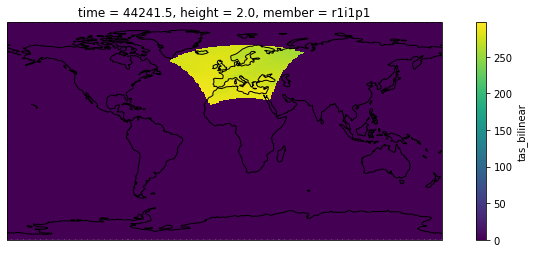

In [18]:
plt.figure(figsize=(12,4));
ax = plt.axes(projection=ccrs.PlateCarree())
ds_out["tas_bilinear"].isel(time=0,member=0).plot.pcolormesh(ax=ax, x='lon', y='lat');
ax.coastlines();

In [19]:
# Mask values == 0 in regridded data (TODO: general solution required in the future!)
for method in method_list:
    ds_out["tas_"+method]=ds_out["tas_"+method].where(ds_out["tas_bilinear"]>0)

In [20]:
# Set longitude range to [-180, 180] for input grid before final comparison
ds["lon"]=ds["lon"].where(ds["lon"]<=180,ds["lon"]-360. )

/home/dkrz/k204212/conda-envs/xesmf0pt4/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


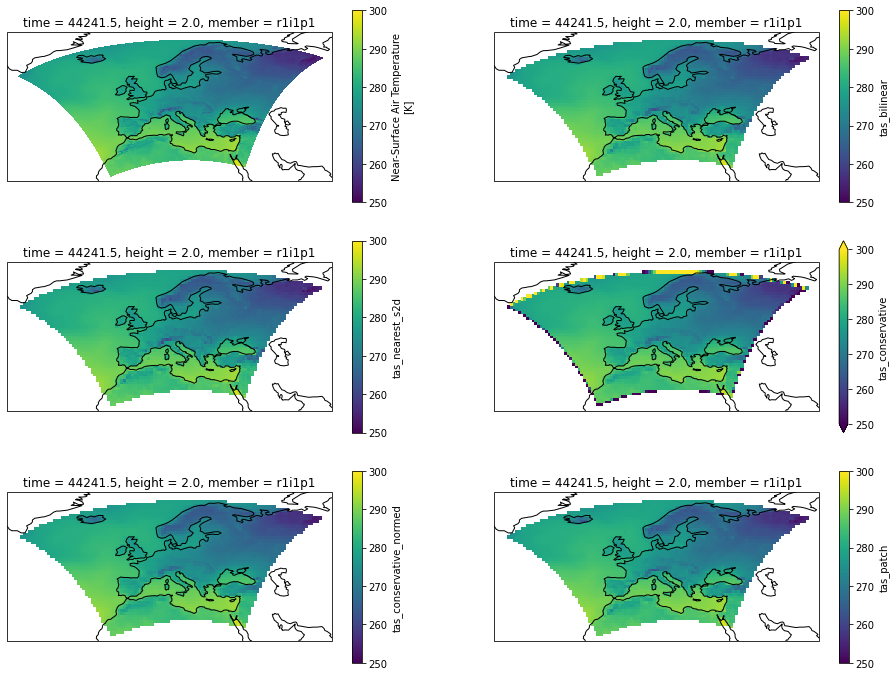

In [21]:
# Create panel plot
fig, axes = plt.subplots(ncols=2, nrows=math.ceil(len(method_list)/2), 
                         figsize=(16, 4*math.ceil(len(method_list)/2)), 
                         subplot_kw={'projection': ccrs.PlateCarree()})

i=0
for ax in axes.flat:
    if i==0:
        # Data on "old" grid  
        ds["tas"].isel(member=0, time=0).plot.pcolormesh(ax=axes[0,0], x='lon', y='lat', vmin=250, vmax=300)
    else:
        # Regridded data
        method=method_list[i-1]
        ds_out["tas_"+method].isel(member=0, time=0).plot.pcolormesh(ax=ax, vmin=250, vmax=300)
    i+=1    
    
    # Coast lines and limits
    ax.coastlines()   
    ax.set_ylim([20, 75]);
    ax.set_xlim([-50, 70]);

### Plotting alternatives to plot data on curvilinear grids

In [22]:
# Using cfplot / cf_xarray
# http://ajheaps.github.io/cf-plot/rotated_pole.html
# http://www.met.reading.ac.uk/~swsheaps/ncas_data_tools/pdf/cf-python_regridding.pdf
import cf
import cf_xarray
import cfplot as cfp

In [23]:
ds.cf.describe()

Axes:
	X: ['rlon']
	Y: ['rlat']
	Z: ['height']
	T: ['time']

Coordinates:
	longitude: ['lon']
	latitude: ['lat']
	vertical: ['height']
	time: ['time']

Cell Measures:
	area: unsupported
	volume: unsupported

Standard Names:
	air_temperature: ['tas']
	grid_latitude: ['rlat']
	grid_longitude: ['rlon']
	height: ['height']



2020-10-08 14:57:54,063 - cf.read_write.read - INFO - File: rgp.nc
2020-10-08 14:57:54,067 - cfdm.read_write.netcdf.netcdfread - INFO - Reading netCDF file: rgp.nc
2020-10-08 14:57:54,068 - cfdm.read_write.netcdf.netcdfread - INFO -     Input netCDF dataset:
        <class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    Conventions: CF-1.5
    dimensions(sizes): y(132), x(229)
    variables(dimensions): float32 y(y), float32 x(x), |S1 rotated_latitude_longitude(), float32 p(y, x)
    groups: 

2020-10-08 14:57:54,070 - cfdm.read_write.netcdf.netcdfread - INFO -     Converting netCDF variable y(y) to a Field:
2020-10-08 14:57:54,079 - cfdm.read_write.netcdf.netcdfread - INFO -     Converting netCDF variable x(x) to a Field:
2020-10-08 14:57:54,085 - cfdm.read_write.netcdf.netcdfread - INFO -     Converting netCDF variable rotated_latitude_longitude() to a Field:
2020-10-08 14:57:54,088 - cfdm.read_write.netcdf.netcdfread - INFO -     Convert

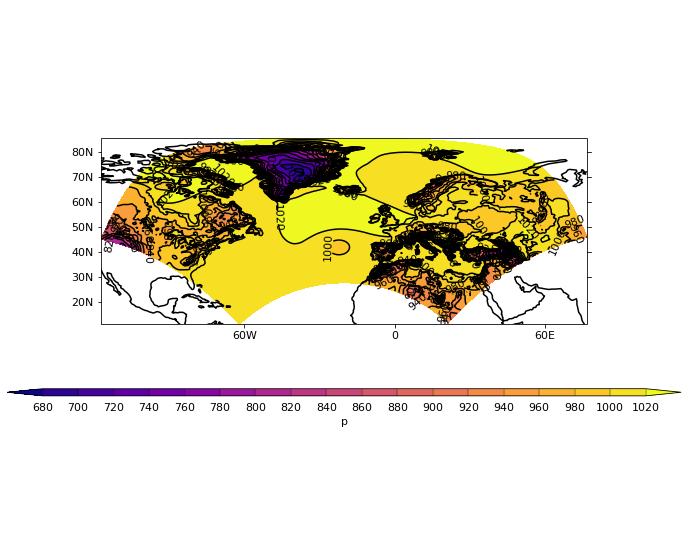

In [24]:
#cf-plot Test dataset
f=cf.read('rgp.nc')[0]
cfp.cscale('plasma')
cfp.con(f)

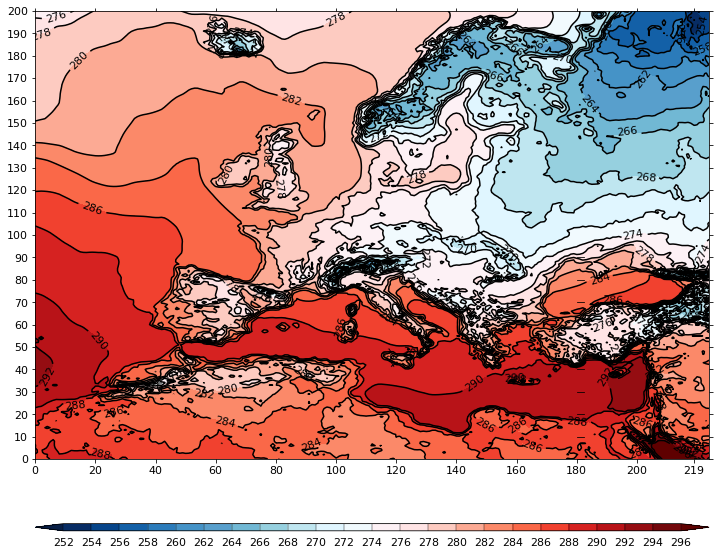

In [25]:
# Not working properly for the 2 CORDEX datasets (= same as rotated projection)
cfp.cscale('temp_19lev')
cfp.mapset(proj='cyl')
cfp.con(ds.tas.isel(member=0, time=0))

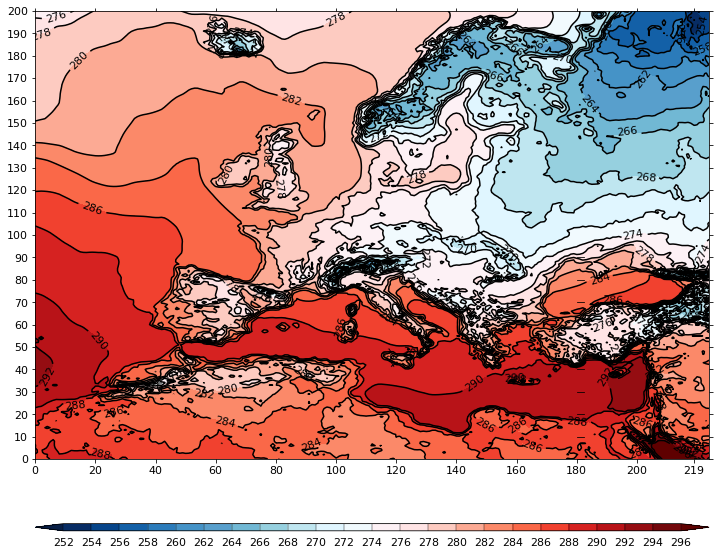

In [26]:
cfp.cscale('temp_19lev')
cfp.mapset(proj='rotated')
cfp.con(ds.tas.isel(member=0, time=0))

/home/dkrz/k204212/conda-envs/xesmf0pt4/lib/python3.8/site-packages/psy_maps/plotters.py:258: UserWarning: Grid mapping variable rotated_latitude_longitude specified but impossible to find!
  warnings.warn(


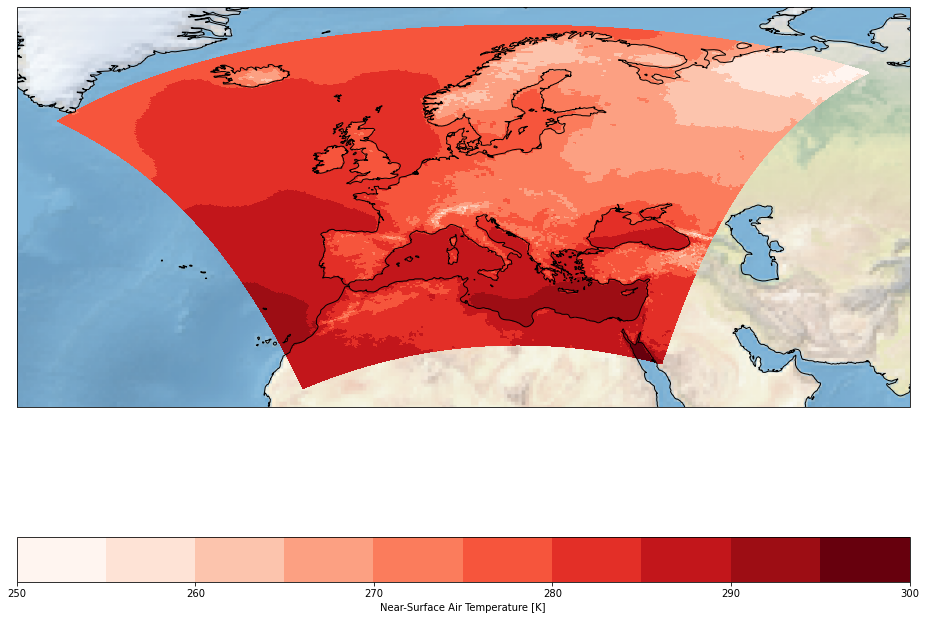

In [27]:
# Using psy-maps / psyplot
# https://psy-maps.readthedocs.io/en/latest/examples/example_ugrid.html#gallery-examples-example-ugrid-ipynb
import psyplot.project as psy

psy.rcParams['plotter.maps.xgrid'] = False
psy.rcParams['plotter.maps.ygrid'] = False
plt.rcParams['figure.figsize'] = [16., 16.]
curvgrid = ds.psy.plot.mapplot(name=["tas"], load=True, cmap="Reds",
    maskleq=0, clabel='{desc}', stock_img=True, lsm='50m')
    
# Adding the datagrid to the plot does not work properly    
#curvgrid.update(datagrid={'c': 'k', 'lw': 0.1})
#curvgrid.update(xgrid="mid", ygrid="mid")


In [ ]:
# Using geoviews (incompatible with clisops/xesmf requirements for matplotlib)
# https://anaconda.org/philippjfr/resampling_grids/notebook
"""
import holoviews as hv
import geoviews as gv

gv.extension('bokeh', 'matplotlib')
%opts QuadMesh Image [width=600 height=400 colorbar=True] Feature [apply_ranges=False]
%opts Image QuadMesh (cmap='RdBu_r')
gvds=gv.Dataset(ds.tas.isel(time=0, member=0))
quadmeshes = gvds.to(gv.QuadMesh, ['rlat', 'rlon'])
"""